# Classification Analysis
This notebook will contain classification analysis for both the sensed and pipelined algorithms. Analysis will be preformed in regards for the sensed and pipelined algorthms themselves, as well as the ensemble algorithms. The analysis for the ensemble algorithm will focus on the HAMF android phones and the HAHF iOS phones.

## Dependencies

In [1]:
# for reading and validating data
import emeval.input.spec_details as eisd
import emeval.input.phone_view as eipv
import emeval.input.eval_view as eiev

In [2]:
import emeval.viz.phone_view as ezpv
import emeval.viz.eval_view as ezev
import emeval.viz.geojson as ezgj

In [3]:
# for analysized view
import emeval.analysed.phone_view as eapv

In [4]:
import emeval.metrics.segmentation as ems

In [5]:
# Metrics helpers
import emeval.metrics.dist_calculations as emd
import emeval.metrics.reference_trajectory as emr

/Users/hlim/opt/anaconda3/envs/emissioneval/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/hlim/opt/anaconda3/envs/emissioneval/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
import pandas as pd
pd.options.display.float_format = '{:.6f}'.format
import arrow

In [7]:
import numpy as np
import scipy as sp
import scipy.interpolate
import scipy.integrate

In [8]:
# For plots
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# For maps
import geopandas as gpd
import shapely as shp
import folium
import branca.element as bre

In [10]:
# For easier debugging while working on modules
import importlib

In [11]:
import arrow

## Load in Phone Views from the file spec

In [12]:
DATASTORE_LOC = "bin/data"
AUTHOR_EMAIL = "shankari@eecs.berkeley.edu"
sd_la = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "unimodal_trip_car_bike_mtv_la")
sd_sj = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "car_scooter_brex_san_jose")
sd_ucb = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "train_bus_ebike_mtv_ucb")

After iterating over 1 entries, entry found
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
After iterating over 1 entries, entry found
Found spec = Multi-modal car scooter BREX trip to San Jose
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
After iterating over 1 entries, entry found
Found spec = Multimodal multi-train, multi-bus, ebike trip to UC Berkeley
Evaluation ran from 2019-07-16T00:00:00-07:00 -> 2020-04-30T00:00:00-07:00


In [13]:
pv_la = eipv.PhoneView(sd_la)

-------------------- About to read transitions from server --------------------
Reading data for android phones
Loading transitions for phone ucb-sdb-android-1
Loading transitions for phone ucb-sdb-android-2
Loading transitions for phone ucb-sdb-android-3
Loading transitions for phone ucb-sdb-android-4
Reading data for ios phones
Loading transitions for phone ucb-sdb-ios-1
Loading transitions for phone ucb-sdb-ios-2
Loading transitions for phone ucb-sdb-ios-3
Loading transitions for phone ucb-sdb-ios-4
-------------------- About to fill calibration ranges --------------------
Processing data for android phones
Processing transitions for phone ucb-sdb-android-1
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-2
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-3
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-4
Filtered 86 total -> 0 calibration

In [14]:
pv_sj = eipv.PhoneView(sd_sj)

-------------------- About to read transitions from server --------------------
Reading data for android phones
Loading transitions for phone ucb-sdb-android-1
Loading transitions for phone ucb-sdb-android-2
Loading transitions for phone ucb-sdb-android-3
Loading transitions for phone ucb-sdb-android-4
Reading data for ios phones
Loading transitions for phone ucb-sdb-ios-1
Loading transitions for phone ucb-sdb-ios-2
Loading transitions for phone ucb-sdb-ios-3
Loading transitions for phone ucb-sdb-ios-4
-------------------- About to fill calibration ranges --------------------
Processing data for android phones
Processing transitions for phone ucb-sdb-android-1
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-2
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-3
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-4
Filtered 86 total -> 0 calibration

In [15]:
pv_ucb = eipv.PhoneView(sd_ucb)

-------------------- About to read transitions from server --------------------
Reading data for android phones
Loading transitions for phone ucb-sdb-android-1
Loading transitions for phone ucb-sdb-android-2
Loading transitions for phone ucb-sdb-android-3
Loading transitions for phone ucb-sdb-android-4
Reading data for ios phones
Loading transitions for phone ucb-sdb-ios-1
Loading transitions for phone ucb-sdb-ios-2
Loading transitions for phone ucb-sdb-ios-3
Loading transitions for phone ucb-sdb-ios-4
-------------------- About to fill calibration ranges --------------------
Processing data for android phones
Processing transitions for phone ucb-sdb-android-1
Filtered 102 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-2
Filtered 90 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-3
Filtered 90 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-4
Filtered 90 total -> 0 calibratio

### Get sensed data for each trip

In [16]:
%%capture
ems.fill_sensed_section_ranges(pv_la)
ems.fill_sensed_section_ranges(pv_sj)
ems.fill_sensed_section_ranges(pv_ucb)

## Get sensed and ground truth temporal histories (timelines)

In [17]:
def get_trip_ss_and_gts_timeline(pv, os, role):
    import emeval.analysed.location_smoothing as eaicl
    import importlib
    importlib.reload(eaicl)
    assert os in ['android', 'ios'], 'UNKNOWN OS'
    assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
    trips = []
    for phone_os, phone_map in pv.map().items():
        if os != phone_os:
            continue
        for phone_label, phone_detail_map in phone_map.items():
            if "control" in phone_detail_map["role"]:
                continue
            for r in phone_detail_map["evaluation_ranges"]:
                if r['eval_role_base'] != role:
                    continue
                tr_ss  = []
                tr_gts = []
                for i, tr in enumerate(r["evaluation_trip_ranges"]):
                    for ss in tr["sensed_section_ranges"]:
                        trip_distances_df = eaicl.add_dist( tr['location_df'] )
                        if 'distance' not in ss.keys():
                            section_dist = trip_distances_df[(trip_distances_df['ts'] >= ss['start_ts']) & (trip_distances_df['ts'] <= ss['end_ts'])].distance.sum()
                            ss['distance'] = section_dist
                        
                        ## append the sensed section data
                        tr_ss.append(ss)

                        # else: 
                        #     print("dropped section with mode: ", ss['mode'], os, role, "\n\tat ", ss['start_ts'], "-", ss['end_ts'])
                        #     print(trip_distances_df)

                    for section in tr["evaluation_section_ranges"]:
                        
                        ## get the ground truth section data
                        section_gt_leg = pv.spec_details.get_ground_truth_for_leg(tr['trip_id_base'],
                                                                                  section['trip_id_base'],
                                                                                  tr['start_ts'],
                                                                                  tr['end_ts'])
                        
                        if section_gt_leg["type"] == "WAITING": 
                            continue
                        gt_shapes = gpd.GeoSeries(eisd.SpecDetails.get_shapes_for_leg(section_gt_leg))
                        gt_dist = 0
                        if len(gt_shapes) > 1:
                            ## GET THE TOTAL GT DISTANCE OF A SECTION
                            gt_linestring = gt_shapes['route']
                            gt_geo_df = emd.linestring_to_geo_df(gt_linestring)
                            gt_loc_df = emd.to_loc_df(gt_geo_df)
                            gt_loc_with_dist_df =  eaicl.add_dist( gt_loc_df )
                            gt_dist = gt_loc_with_dist_df['distance'].sum()

                        gts = {'start_ts': section['start_ts'], 
                               'end_ts': section['end_ts'], 
                               'mode': section_gt_leg['mode'],
                               'distance' : gt_dist}
                        tr_gts.append(gts)
                        
                # now, we build a timeline for each trip
                trip = tr.copy()
                trip['ss_timeline']  = tr_ss
                trip['gts_timeline'] = tr_gts
                trip['os'] = os
                trips.append(trip)
    return trips

## Define the Base Mode Maps

#### raw base mode map

In [18]:
RBMM = {
    "WALKING": "WALKING",
    "RUNNING" : "WALKING", 
    "CYCLING" : "CYCLING",
    "BICYCLING": "CYCLING",
    "E_BIKE" : "CYCLING",
    "ESCOOTER": "CYCLING", 
    "AUTOMOTIVE" : "AUTOMOTIVE",
    "BUS": "AUTOMOTIVE",
    "TRAIN": "AUTOMOTIVE",
    "LIGHT_RAIL": "AUTOMOTIVE",
    "SUBWAY": "AUTOMOTIVE",
    "CAR": "AUTOMOTIVE",
    "AIR_OR_HSR": "AIR_OR_HSR",
    "MISALIGNED" : "MISALIGNED", 
    "NO_SENSED" : "MISALIGNED", 
    "NO_GT" : "MISALIGNED", 
    "INVALID" : "UNKNOWN", 
    "UNKNOWN" : "UNKNOWN", 
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

#### cleaned base mode map

e-mission-server.emission.core.wrapper.motionactivity.py

In [19]:
CBMM = {
    0 : 'AUTOMOTIVE', 
    1 : 'CYCLING', 
    2 : 'WALKING', 
    3 : 'WALKING', 
    4 : 'UNKNOWN', 
    5 : 'WALKING', 
    7 : 'WALKING', 
    8 : 'WALKING', 
    9 : 'UNKNOWN', 
    10 : 'AUTOMOTIVE', 
    11 : 'AIR_OR_HSR', 
    "WALKING": "WALKING",
    "RUNNING" : "WALKING", 
    "CYCLING" : "CYCLING",
    "BICYCLING": "CYCLING",
    "E_BIKE" : "CYCLING",
    "ESCOOTER": "CYCLING", 
    "AUTOMOTIVE" : "AUTOMOTIVE",
    "BUS": "AUTOMOTIVE",
    "TRAIN": "AUTOMOTIVE",
    "LIGHT_RAIL": "AUTOMOTIVE",
    "SUBWAY": "AUTOMOTIVE",
    "CAR": "AUTOMOTIVE",
    "AIR_OR_HSR": "AIR_OR_HSR", 
    "NO_SENSED" : "MISALIGNED", 
    "NO_GT" : "MISALIGNED",
    "MISALIGNED" : "MISALIGNED", 
    "UNKNOWN" : "UNKNOWN",
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

### inferred base mode maps

e-mission-server.emission.core.wrapper.modeprediction.py

#### random forest base mode map

In [20]:
RFBMM = {0 : 'UNKNOWN',    # UNKNOWN
        1 : 'WALKING',    # WALKING
        2 : 'CYCLING',    # BICYCLING
        3 : 'BUS',        # BUS
        4 : 'TRAIN',      # TRAIN
        5 : 'CAR',        # CAR
        6 : 'AIR_OR_HSR', # AIR_OR_HSR
        7 : 'TRAIN',      # SUBWAY
        8 : 'TRAIN',      # TRAM
        9 : 'TRAIN',      # LIGHT_RAIL
         "WALKING": "WALKING",
         "CYCLING" : "CYCLING",
         "BICYCLING": "CYCLING",
         "E_BIKE" : "CYCLING",
         "ESCOOTER": "CYCLING", 
         "BUS": "BUS",
         "TRAIN": "TRAIN",
         "LIGHT_RAIL": "TRAIN",
         "SUBWAY": "TRAIN",
         "CAR": "CAR",
         "AIR_OR_HSR": "AIR_OR_HSR",
         "UNKNOWN" : "UNKNOWN",
         "NO_SENSED" : "MISALIGNED", 
         "NO_GT" : "MISALIGNED",
         "MISALIGNED" : "MISALIGNED", 
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

#### rule+GIS base mode map

In [21]:
GISBMM = {0 : 'UNKNOWN',    # UNKNOWN
        1 : 'WALKING',    # WALKING
        2 : 'CYCLING',    # BICYCLING
        3 : 'BUS',        # BUS
        4 : 'TRAIN',      # TRAIN
        5 : 'CAR',        # CAR
        6 : 'AIR_OR_HSR', # AIR_OR_HSR
        7 : 'SUBWAY',      # SUBWAY
        8 : 'TRAIN',      # TRAM
        9 : 'TRAIN',      # LIGHT_RAIL
         "WALKING": "WALKING",
         "CYCLING" : "CYCLING",
         "BICYCLING": "CYCLING",
        "E_BIKE" : "CYCLING",
         "ESCOOTER": "CYCLING", 
         "BUS": "BUS",
         "TRAIN": "TRAIN",
         "LIGHT_RAIL": "TRAIN",
         "SUBWAY": "TRAIN",
         "CAR": "CAR",
         "AIR_OR_HSR": "AIR_OR_HSR",
         "UNKNOWN" : "UNKNOWN",
         "NO_SENSED" : "MISALIGNED", 
         "NO_GT" : "MISALIGNED",
         "MISALIGNED" : "MISALIGNED", 
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

#### Pad the start at end of the timelines for a given trip, while also filling in gaps in the middle

In [23]:
def align_timelines(trip):
    ss_timeline = trip['ss_timeline']
    gt_timeline = trip['gts_timeline']
    # print("before ss: ", ss_timeline)
    # print("before gt: ", gt_timeline)
    ss_aligned_timeline = []
    gt_aligned_timeline = []

    running_ss_distance = 0
    running_gt_distance = 0

    ####### FILL IN SENSED TIMELINE #######
    ### fill in start ###
    if len(ss_timeline) == 0:
        if len(gt_timeline) == 0:
            return ss_timeline, gt_timeline
        else: # no_sensed_start over entire timeline
            total_gt_dist = 0
            for gt_section in gt_timeline:
                total_gt_dist += gt_section['distance']

            ss_timeline.append(
                {
                    'mode' : 'NO_SENSED_START',
                    'start_ts' : gt_section['start_ts'],
                    'end_ts' : gt_section['end_ts'],
                    'distance' : total_gt_dist
                }
            )
    if len(gt_timeline) == 0:
        total_ss_dist = 0
        for ss_section in ss_timeline:
            total_ss_dist += ss_section['distance']
        gt_timeline.append(
            {
                'mode' : 'NO_GT_START',
                'start_ts' : ss_section['start_ts'],
                'end_ts' : ss_section['end_ts'],
                'distance' : total_ss_dist
            }
        )
    if 'data' in ss_timeline[0]:
        start_misalignment = ss_timeline[0]['data']['start_ts'] - gt_timeline[0]['start_ts']
        end_misalignment = ss_timeline[-1]['data']['end_ts'] - gt_timeline[-1]['end_ts']
    else:
        start_misalignment = ss_timeline[0]['start_ts'] - gt_timeline[0]['start_ts']
        end_misalignment = ss_timeline[-1]['end_ts'] - gt_timeline[-1]['end_ts']

    if start_misalignment > 0: # if ss_timeline starts after gt_timeline
        if 'data' in ss_timeline[0].keys():
            ss_timeline[0] = ss_timeline[0]['data']
        
        # Distance travelled in gt while there was no_sensed_start = distance of no_sensed_start
        # Find average speed over the entirety of the first gt section
        speed = gt_timeline[0]['distance']/(gt_timeline[0]['end_ts'] - gt_timeline[0]['start_ts'])
        # Use speed and start_alignment (duration of no_sensed_start) to find distance travelled during duration of no_sensed_start
        distance = speed * start_misalignment
        
        ss_aligned_timeline.append(
            {
                'mode' : 'NO_SENSED_START',
                'start_ts' : ss_timeline[0]['start_ts'] - start_misalignment,
                'end_ts' : ss_timeline[0]['start_ts'],
                'start_distance' : running_ss_distance,
                'end_distance' : running_ss_distance + distance
            }
        )

        running_ss_distance += distance

    ### fill in meat ###
    for ss in ss_timeline:
        if 'data' in ss.keys():
            ss = ss['data']
        if 'sensed_mode' in ss.keys():
            ss['mode'] = ss['sensed_mode']
        if len(ss_aligned_timeline) > 0:
            ## check to see if there is a gap between last aligned sensed section and the new section we want to align ##
            if ss['start_ts'] - ss_aligned_timeline[-1]['end_ts'] > 0:
                ## fill in the blank
                # look for gt sections that happened in gap between end of last aligned section and start of the next section (ss) that we want to align
                distance = 0
                for gt_section in gt_timeline:
                    if (gt_section['start_ts'] >= ss_aligned_timeline[-1]['end_ts'] and gt_section['start_ts'] < ss['start_ts']) \
                    or (gt_section['end_ts'] > ss_aligned_timeline[-1]['end_ts'] and gt_section['end_ts'] <= ss['start_ts']):
                        # calculate speed of a gt_section that happened during in no_sensed_middle gap
                        speed = gt_section['distance']/(gt_section['end_ts'] - gt_section['start_ts'])
                        
                        # find the amount of time the no_sensed section overlapped with the gt_section
                        start_time, end_time = 0, 0
                        if gt_section['start_ts'] - ss_aligned_timeline[-1]['end_ts'] < 0: # gt_section started before end of last aligned sensed section
                            start_time = ss_aligned_timeline[-1]['end_ts']
                        else: start_time = gt_section['start_ts']
                        if gt_section['end_ts'] - ss['start_ts']  < 0: # gt_section ends before start of next ss
                            end_time = gt_section['end_ts']
                        else: end_time = ss['start_ts']

                        time = end_time - start_time

                        # use calculated time and speed to find distance travelled in the parts of gt_section that overlapped (temporally) with no_sensed section
                        distance += speed * time

                ss_aligned_timeline.append(
                    {
                        'mode' : 'NO_SENSED_MIDDLE', 
                        'start_ts' : ss_aligned_timeline[-1]['end_ts'],
                        'end_ts' : ss['start_ts'],
                        'start_distance': running_ss_distance,
                        'end_distance' : running_ss_distance + distance,
                        'distance' : distance
                    }
                )

                running_ss_distance += distance

        ## the timeline is continuous, and we can fill our section ##
        # if no gap, still need to set start and end dist.
        ss_aligned_timeline.append(
                {
                    'mode' : ss['mode'],
                    'start_ts' : ss['start_ts'],
                    'end_ts' : ss['end_ts'],
                    'start_distance': running_ss_distance,
                    'end_distance' : running_ss_distance + ss['distance'],
                    'distance' : ss['distance']
                }
            )
        
        running_ss_distance += ss['distance']

    ### fill in end ###
    if end_misalignment < 0: # sensed ends before gt = no_sensed_end
        ss = ss_timeline[-1]
        if 'data' in ss.keys():
            ss = ss['data']
        # Distance travelled by gt during no_sensed_end
        # Find average speed of the entirety of the last gt section
        speed = gt_timeline[-1]['distance']/(gt_timeline[-1]['end_ts'] - gt_timeline[-1]['start_ts'])
        # use speed and end_misalignment (duration of no_sensed_end) to find distance
        distance = speed * -end_misalignment

        ss_aligned_timeline.append(
            {
                'mode' : 'NO_SENSED_END',
                'start_ts' : ss['end_ts'],
                'end_ts' : ss['end_ts'] - end_misalignment, 
                'start_distance' : running_ss_distance,
                'end_distance' : running_ss_distance + distance,
                'distance' : distance
            }
        )
        running_ss_distance += distance
    ####### FILL IN GT TIMELINE #######
    ### fill in start ###
    if start_misalignment < 0: # gt starts after ss
        # For no gt_start, find average speed of first sensed section
        speed = ss_timeline[0]['distance']/(ss_timeline[0]['end_ts'] - ss_timeline[0]['start_ts'])
        # then find the distance travelled by the first sensed section for the duration of no_gt_start
        distance = speed * -start_misalignment

        gt_aligned_timeline.append(
            {
                'mode' : 'NO_GT_START',
                'start_ts' : gt_timeline[0]['start_ts'] + start_misalignment,
                'end_ts' : gt_timeline[0]['start_ts'],
                'start_distance' : running_gt_distance,
                'end_distance' : running_gt_distance + distance,
                'distance' : distance
            }
        )
        running_gt_distance += distance
    ### fill in meat ###
    for gts in gt_timeline:
        if len(gt_aligned_timeline) > 0: 
            
            if gts['start_ts'] - gt_aligned_timeline[-1]['end_ts'] > 0: # there's a gap between last aligned gt section and the next gt section we want to align
                ## fill in the gap ## 
                # look for ss that happened in gap
                distance = 0
                for sensed_section in ss_timeline:
                    if (sensed_section['start_ts'] >= gt_aligned_timeline[-1]['end_ts'] and sensed_section['start_ts'] < gts['start_ts']) \
                    or (sensed_section['end_ts'] > gt_aligned_timeline[-1]['end_ts'] and sensed_section['end_ts'] <= gts['start_ts']):
                        # calculate avg speed of sensed_section
                        speed = sensed_section['distance']/(sensed_section['end_ts'] - sensed_section['start_ts'])
                        # find amt of time sensed_section overlapped with no_gt_middle section
                        start_time, end_time = 0, 0
                        if sensed_section['start_ts'] - gt_aligned_timeline[-1]['end_ts'] < 0: # sensed_section started before end of last aligned gt section
                            start_time = gt_aligned_timeline[-1]['end_ts']
                        else: start_time = sensed_section['start_ts']
                        if sensed_section['end_ts'] - gts['start_ts']  < 0: # sensed_section ends before start of next gts
                            end_time = sensed_section['end_ts']
                        else: end_time = gts['start_ts']

                        time = end_time - start_time

                        # use calculated time and speed to find distance travelled in the parts of sensed_section that overlapped (temporally) with no_gt section
                        distance += speed * time
            
                gt_aligned_timeline.append(
                    {
                        'mode' : 'NO_GT_MIDDLE',
                        'start_ts' : gt_aligned_timeline[-1]['end_ts'],
                        'end_ts' : gts['start_ts'],
                        'start_distance' : running_gt_distance,
                        'end_distance' : running_gt_distance + distance,
                        'distance' : distance
                    }
                )

                running_gt_distance += distance
        # if no gap, just add next section
        gt_aligned_timeline.append(
            {
                'mode' : gts['mode'],
                'start_ts' : gts['start_ts'],
                'end_ts' : gts['end_ts'],
                'start_distance' : running_gt_distance,
                'end_distance' : running_gt_distance + gts['distance'],
                'distance' : gts['distance']
            }
        )
        running_gt_distance += gts['distance']
        
    ### fill in end ###
    if end_misalignment > 0: #gt ends before sensed
        # find avg speed of last sensed section
        speed = ss_timeline[-1]['distance']/(ss_timeline[-1]['end_ts'] - ss_timeline[-1]['start_ts'])
        # find distance travelled in sensed section for the duration of no_gt_end
        distance = speed * end_misalignment

        gt_aligned_timeline.append(
            {
                'mode' : 'NO_GT_END',
                'start_ts' : gt_aligned_timeline[-1]['end_ts'],
                'end_ts' : gt_aligned_timeline[-1]['end_ts'] + end_misalignment,
                'start_distance' : running_gt_distance,
                'end_distance' : running_gt_distance + distance,
                'distance' : distance
            }
        )
        running_gt_distance += distance

    print("ss: ", ss_aligned_timeline)
    print("gt: ", gt_aligned_timeline)
    return ss_aligned_timeline, gt_aligned_timeline




#### Get the classification metrics (true/false positive, true/false negative) for each Base Mode for a given trip/set-of-trips

In [24]:
def get_binary_class_in_sec(os, role, pv, BASE_MODE, test=False, test_trip=None):
    if not test:
        if type(pv) is not list: pv = [pv]
        trips = []
        for v in pv:
            trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
    else:
        trips = test_trip if type(test_trip) is list else [test_trip]
    TP, FN, FP, TN = {}, {}, {}, {}
    for trip in trips:
        ss_timeline, gt_timeline = align_timelines(trip)
        for mode in set(BASE_MODE.values()):
            for ss in ss_timeline:
                for gts in gt_timeline:
                    if ss['end_ts'] >= gts['start_ts'] and ss['start_ts'] <= gts['end_ts']:
                        dur = min(ss['end_ts'], gts['end_ts']) - max(ss['start_ts'], gts['start_ts'])
                        if BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                            TP[mode] = TP.setdefault(mode, 0) + dur
                        elif BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] != BASE_MODE[gts['mode']]:
                            FP[mode] = FP.setdefault(mode, 0) + dur
                        elif BASE_MODE[mode] != BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                            FN[mode] = FN.setdefault(mode, 0) + dur
                        else:
                            TN[mode] = TN.setdefault(mode, 0) + dur
                    
    return TP, FP, FN, TN

# $F_\beta$ score
$$
F_\beta = \frac {(1 + \beta^2) \cdot \mathrm{true\ positive} }{(1 + \beta^2) \cdot \mathrm{true\ positive} + \beta^2 \cdot \mathrm{false\ negative} + \mathrm{false\ positive}}
$$

In [25]:
def get_F_score(os, role, pv, BASE_MODE, beta=1, test=False, test_trip=None):
    if not test:
        assert os in ['android', 'ios'], 'UNKNOWN OS'
        assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
        (TP, FP, FN, TN) = get_binary_class_in_sec(os, role, pv, BASE_MODE)
    else:
        (TP, FP, FN, TN) = get_binary_class_in_sec(os, role, pv, BASE_MODE, test=True, test_trip=test_trip)
    F_score = {}
    for mode in set(BASE_MODE.values()):
        numerator   = (1 + beta**2) * TP.setdefault(mode, 0)
        denominator = (1+beta**2) * TP.setdefault(mode, 0) + beta**2*FN.setdefault(mode, 0) + FP.setdefault(mode, 0)
        try:
            F_score[mode] = (numerator)/(denominator)
        except:
            F_score[mode] = np.nan
    # initializing K 
    K = 10
    for key in F_score:

        # rounding to K using round()
        F_score[key] = round(F_score[key], K)
    return F_score

#### Get the support for each base mode in a set of trips, which is the sum of confusion matrix row sums for each mode that maps to a base mode, $M_{bm} = \{ m : b(m) = bm, m \in M \}$ 

In [26]:
def get_support(os, role, pv, BASE_MODE):
    if type(pv) is not list: pv = [pv]
    trips = []
    for v in pv:
        trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
    support = {}
    for trip in trips:
        ## get gts dur
        gt_dur = 0
        for gts in trip['gts_timeline']:
            mode = BASE_MODE[gts['mode']]
            support[mode] = support.setdefault(mode, 0) + gts['end_ts'] - gts['start_ts']
            gt_dur += (gts['end_ts'] - gts['start_ts'])
        ## check if there is a NO_GT mode
        ss_dur = 0
        for ss in trip['ss_timeline']:
            try:
                ss_dur += (ss['end_ts'] - ss['start_ts'])
            except:
                ss_dur += (ss['data']['end_ts'] - ss['data']['start_ts'])
        support['NO_GT'] = support.setdefault('NO_GT', 0) + max(0, ss_dur - gt_dur)
    return support

### Weighted $F_1$ Score

\begin{equation}\label{eq:w_f_score}
    F_1^{avg} = \sum_{i=1}^{|BM|} \left[  \sum_{j=1} ^ {|M_{bm_i}|} \sum_{k = 1}^{|M^{inf}|} cm_{j, k} \right] \cdot F_1^{bm}
\end{equation}

In [27]:
def weighted_f_score(os, role, pv, BASE_MODE):
    support = get_support(os, role, pv, BASE_MODE)
    total_support = sum(support.values())
    F_scores = get_F_score(os, role, pv, BASE_MODE)
    weighted_f_score = sum(
        support[mode]/total_support * F_scores.setdefault(mode, 0) 
        for mode in support.keys()
        if not np.isnan(F_scores.setdefault(mode, 0))
    )
    return weighted_f_score

In [28]:
def plot_f_scores(os):
    fig, ax = plt.subplots(1,3, figsize = (15,5), dpi=300, sharey=True, sharex=True)
    for i, role in enumerate(['HAHFDC', 'HAMFDC', 'MAHFDC']):
        raw   = get_F_score(os, role, [pv_la, pv_sj, pv_ucb], RBMM)
        m_clean = get_F_score(os, role, [mcv_la, mcv_sj, mcv_ucb], CBMM)
        g_clean = get_F_score(os, role, [gcv_la, gcv_sj, gcv_ucb], CBMM)
        rf    = get_F_score(os, role, [rfv_la, rfv_sj, rfv_ucb], RFBMM)
        gis   = get_F_score(os, role, [gisv_la, gisv_sj, gisv_ucb], GISBMM)
        df = pd.DataFrame(
            [raw, m_clean, g_clean, rf, gis], 
            index = ['raw', 'master clean', 'GIS clean', 'random forest', 'GIS'], 
            columns=['WALKING', 'CYCLING', 'AUTOMOTIVE', 'CAR', 'BUS', 'TRAIN', 'SUBWAY']
        )
        
        df.T.plot(style='o', ax=ax[i], title=f' {role} ').legend(loc='lower left')
        ax[i].set_xticks(range(len(df.T)))
        ax[i].set_xticklabels(df.columns, rotation = 80)
    title = f"$F_1$ Scores by Base Mode for Phones Running {os} at Various Configuration Settings"
    plt.suptitle(title, weight='bold', size='x-large')
    fig.savefig(f"images/f_scores_for_{os}",  bbox_inches="tight")

#### Plot $F$ scores for android/ios on select configuration settings

In [29]:
def plot_f_scores_selected():
    fig, ax = plt.subplots(1,2, figsize = (10,3), dpi=300, sharey=True, sharex=True)
    for i, (os, role) in enumerate([['android', 'HAMFDC'], ['ios', 'HAHFDC']]):
        raw   = get_F_score(os, role, [pv_la, pv_sj, pv_ucb], RBMM)
        m_clean = get_F_score(os, role, [mcv_la, mcv_sj, mcv_ucb], CBMM)
        g_clean = get_F_score(os, role, [gcv_la, gcv_sj, gcv_ucb], CBMM)
        rf    = get_F_score(os, role, [rfv_la, rfv_sj, rfv_ucb], RFBMM)
        gis   = get_F_score(os, role, [gisv_la, gisv_sj, gisv_ucb], GISBMM)
        df = pd.DataFrame(
            [raw, m_clean, g_clean, rf, gis], 
            index = ['raw', 'master clean', 'GIS clean', 'random forest', 'GIS'], 
            columns=['WALKING', 'CYCLING', 'AUTOMOTIVE', 'CAR', 'BUS', 'TRAIN', 'SUBWAY']
        )
        
        df.T.plot(style='o', ax=ax[i], title=f'$F_1$ Scores by Base Mode \n{os}:{role} ').legend(loc='lower left')
        ax[i].set_xticks(range(len(df.T)))
        ax[i].set_xticklabels(df.columns, rotation = 80)
#     title = f"$F_1$ Scores by Base Mode for Selected OS Setting Configurations"
#     plt.suptitle(title, weight='bold', size='x-large')
    fig.savefig(f"images/f_scores_selected",  bbox_inches="tight")

## Confusion Matrix
We will now generate confusion matrices based off OS and role, with the acctual modes as the rows, the predicted modes as the columns, and the entries as the base unit for the duration measurement

#### cleaned index map

In [30]:
CIM = {0 : 'IN_VEHICLE', 
       1 : 'BICYCLING', 
       2 : 'ON_FOOT', 
       3 : 'STILL', 
       4 : 'UNKNOWN', 
       5 : 'TILTING', 
       7 : 'WALKING', 
       8 : 'RUNNING', 
       9 : 'NONE', 
       10 : 'STOPPED_WHILE_IN_VEHICLE', 
       11 : 'AIR_OR_HSR'}

#### inferred index map

In [31]:
IIM = {
    0 : 'UNKNOWN', 
    1 : 'WALKING', 
    2 : 'BICYCLING', 
    3 : 'BUS', 
    4 : 'TRAIN', 
    5 : 'CAR', 
    6 : 'AIR_OR_HSR',
    7 : 'SUBWAY',
    8 : 'TRAM',
    9 : 'LIGHT_RAIL'
}

In [32]:
def get_confusion_matrix(os, role, pv, test=False, test_trip=None):
    cm_l = []
    if not test:
        assert os in ['android', 'ios'], 'UNKNOWN OS'
        assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
        if type(pv) is not list:
            pv = [pv]
        trips = []
        for v in pv :
            trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
    else:
        trips = test_trip if type(test_trip) is list else [test_trip]
    for trip in trips:
        ss_timeline, gt_timeline = align_timelines(trip)
        for ss in ss_timeline:
            cm = {}
            for gts in gt_timeline:
                # if ss['end_ts'] >= gts['start_ts'] and ss['start_ts'] <= gts['end_ts']:
                #     dur = min(ss['end_ts'], gts['end_ts']) - max(ss['start_ts'], gts['start_ts'])
                #     cm[gts['mode']] = cm.setdefault(gts['mode'], 0) + dur
                if ss['end_distance'] >= gts['start_distance'] and ss['start_distance'] <= gts['end_distance']:
                    distance = min(ss['end_distance'], gts['end_distance']) - max(ss['start_distance'], gts['start_distance'])
                    cm[gts['mode']] = cm.setdefault(gts['mode'], 0) + distance
            cm['sensed_mode'] = ss['mode']
            
            cm_l.append(cm)
    return cm_l

In [33]:
sort_dict = {
    'WALKING' : 0,
    'RUNNING' : 1,
    'ON_FOOT' : 2,
    'CYCLING' : 3,
    'BICYCLING' : 4,
    'AUTOMOTIVE' : 5,
    'IN_VEHICLE' : 6,
    'CAR': 7,
    'BUS': 8,
    'SUBWAY' : 9,
    'LIGHT_RAIL' : 10,
    'TRAIN' : 11,
    'AIR_OR_HSR' : 12,
    'INVALID' : 13,
    'UNKNOWN' : 14,
    'NO_SENSED_START' : 15,
    'NO_SENSED_MIDDLE' : 16,
    'NO_SENSED_END' : 17
}
def sort_key(s):
    return sort_dict[s]

In [34]:
def plot_cm(os, pv, d_type, INDEX_MAP=None):
    fig, ax = plt.subplots(1,3, figsize=(22,10), dpi=300, sharey=True)
    y=.95
    fig.text(0.5, 0.0, 'Predicted Label', ha='center', fontsize='xx-large')
    fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical', fontsize='xx-large')
    for k, role in enumerate(["HAHFDC", "HAMFDC", "MAHFDC"]):
        if d_type =='raw':
            title = f"Confusion Matrices for Raw Output Data on Phones Running {os} \n by Calibration Settings"
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum()
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
            fname = f"images/raw_cm_{os}"
        elif d_type == 'clean':
            title = f"Confusion Matrices for Clean Output Data on Phones Running {os} \n by Calibration Settings"
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
            fname = f"images/clean_cm_{os}"
        elif d_type == 'random_forest' or 'gis':
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
            fname = f"images/{d_type}_cm_{os}"
            if d_type == 'random_forest':
                title = f"Confusion Matrices for Inferred Output Data (Random Forest) on Phones Running {os} \n by Calibration Settings"
            else:
                title = f"Confusion Matrices for Inferred Output Data (GIS) on Phones Running {os} \n by Calibration Settings"
        else:
            assert 0, f'INVALID d_type {d_type}'
        df = df.reindex(
            columns=['WALKING', 'BICYCLING', 'E_BIKE', 'ESCOOTER', 'CAR', 'BUS', 'SUBWAY', 'LIGHT_RAIL', 'TRAIN', 'NO_GT_START', 'NO_GT_MIDDLE', 'NO_GT_END']
        ).fillna(0)
#         df = df.div(df.sum(axis=1), axis=0)
        cm = ax[k].imshow(df.transpose(), interpolation='nearest',  cmap=plt.cm.coolwarm, aspect='auto')
        ax[k].set_title(role)
    #     plt.colorbar(cm, ax=ax[0])
        tick_marks = np.arange(len(df))
        ax[k].set_yticks(np.arange(len(df.columns)))
        ax[k].set_xticks(np.arange(len(df)))
        ax[k].set_yticklabels(df)
        ax[k].set_xticklabels(df.index, rotation=80)
        color_thresh = df.max().max() / 4
        for i, j in itertools.product(range(df.shape[1]), range(df.shape[0])  ):
            ax[k].text(j, i, (int(df.transpose().iat[i,j])), horizontalalignment='center', 
                   color='white' 
                       if df.transpose().iat[i,j] < color_thresh 
#                            or df.transpose().iat[i,j] in df.max()
                       else 'black')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cm, cax=cbar_ax)
    plt.suptitle(title, weight='bold', size='x-large', y=y)

    plt.savefig(fname=fname,  bbox_inches="tight")

#### plot the confusion matrices at each pipeline output stage on android/ios for select configuration settings

In [35]:
def plot_select_cm(os, role):
    IIM = {0 : 'UNKNOWN', 1 : 'WALKING', 2 : 'BICYCLING', 3 : 'BUS', 4 : 'TRAIN', 5 : 'CAR', 6 : 'AIR_OR_HSR', 7 : 'SUBWAY', 8 : 'TRAM', 9 : 'LIGHT_RAIL'
    }
    CIM = {0 : 'IN_VEHICLE', 1 : 'BICYCLING', 2 : 'ON_FOOT', 3 : 'STILL', 4 : 'UNKNOWN', 5 : 'TILTING', 7 : 'WALKING', 8 : 'RUNNING', 9 : 'NONE', 10 : 'STOPPED_WHILE_IN_VEHICLE', 11 : 'AIR_OR_HSR'}
    fig, ax = plt.subplots(1,5, figsize=(30,8), dpi=300, sharey=True)
    y=.95
    fig.text(0.5, -0.1, 'Predicted Label', ha='center', fontsize='xx-large')
    fig.text(0.08, 0.5, 'True Label', va='center', rotation='vertical', fontsize='xx-large')
    title = f"Confusion Matrices for Phones Running {os}:{role}"
    fname = f"images/selected_cm_{os}"
    for k, pv in enumerate(
        [[pv_la, pv_sj, pv_ucb], 
         [mcv_la, mcv_sj, mcv_ucb],
         [gcv_la, gcv_sj, gcv_ucb], 
         [rfv_la, rfv_sj, rfv_ucb], 
         [gisv_la, gisv_sj, gisv_ucb]]):
        if k == 0:
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum()
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        elif k == 1 or k == 2:
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum().rename(index=CIM)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))

        else:
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum().rename(index=IIM)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        df = df.reindex(
            columns=['WALKING', 'BICYCLING', 'E_BIKE', 'ESCOOTER', 'CAR', 'BUS', 'SUBWAY', 'LIGHT_RAIL', 'TRAIN', 'NO_GT_START', 'NO_GT_MIDDLE', 'NO_GT_END']
        ).fillna(0)
        cm = ax[k].imshow(df.transpose(), interpolation='nearest',  cmap=plt.cm.coolwarm, aspect='auto')
        title_map = {0 : f'raw output confusion matrix \n{os}:{role}', 
                     1 : f'master clean output confusion matrix \n{os}:{role}',
                     2 : f'GIST clean output confusion matrix \n{os}:{role}', 
                     3 : f'random forest output confusion matrix \n{os}:{role}', 
                     4 : f'GIS output confusion matrix \n{os}:{role}'}
        ax[k].set_title(title_map[k])
        tick_marks = np.arange(len(df))
        ax[k].set_yticks(np.arange(len(df.columns)))
        ax[k].set_xticks(np.arange(len(df)))
        ax[k].set_yticklabels(df)
        ax[k].set_xticklabels(df.index, rotation=80)
        color_thresh = df.max().max() / 4
        for i, j in itertools.product(range(df.shape[1]), range(df.shape[0])  ):
            ax[k].text(j, i, (int(df.transpose().iat[i,j])), horizontalalignment='center', 
                   color='white' 
                       if df.transpose().iat[i,j] < color_thresh 
                       else 'black')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.825, 0.15, 0.025, 0.7])
    fig.colorbar(cm, cax=cbar_ax)
#     plt.suptitle(title, weight='bold', size='x-large', y=y)

#     plt.savefig(fname=fname,  bbox_inches="tight")

## Analyzed Data

#### cleaned view

In [36]:
import copy

In [37]:
MASTER_DATA_LOC = "bin/data/master_9b70c97"
master_spec = eisd.FileSpecDetails(MASTER_DATA_LOC, AUTHOR_EMAIL)

In [38]:
GIS_DATA_LOC = "bin/data/gis_9b679e3/"
gis_spec = eisd.FileSpecDetails(GIS_DATA_LOC, AUTHOR_EMAIL)

In [38]:
mcv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
mcv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
mcv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))

Finished copying unimodal_trip_car_bike_mtv_la, starting overwrite
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY

In [39]:
gcv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
gcv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
gcv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))

Finished copying unimodal_trip_car_bike_mtv_la, starting overwrite
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY

#### inferred view random forest

sensed_db

In [40]:
rfv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
rfv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
rfv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))

Finished copying unimodal_trip_car_bike_mtv_la, starting overwrite
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY

#### inferred view GIS
mobilitynet_db

In [39]:
gisv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
gisv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
gisv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))

Finished copying unimodal_trip_car_bike_mtv_la, starting overwrite
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY

# Results 

#### Raw data

In [40]:
get_confusion_matrix('ios', 'HAHFDC', gisv_ucb)

ss:  [{'mode': 'NO_SENSED_START', 'start_ts': 1563979902.260114, 'end_ts': 1563980044.385489, 'start_distance': 0, 'end_distance': 174.96110286888847}, {'mode': 1, 'start_ts': 1563980044.385489, 'end_ts': 1563981269.9858723, 'start_distance': 174.96110286888847, 'end_distance': 1207.5355877927288, 'distance': 1032.5744849238404}, {'mode': 'NO_SENSED_MIDDLE', 'start_ts': 1563981269.9858723, 'end_ts': 1563982185.4986596, 'start_distance': 1207.5355877927288, 'end_distance': 1737.6482029188653, 'distance': 530.1126151261365}, {'mode': 4, 'start_ts': 1563982185.4986596, 'end_ts': 1563984657.9924605, 'start_distance': 1737.6482029188653, 'end_distance': 37930.7593710521, 'distance': 36193.11116813324}, {'mode': 'NO_SENSED_MIDDLE', 'start_ts': 1563984657.9924605, 'end_ts': 1563984658.9924257, 'start_distance': 37930.7593710521, 'end_distance': 37930.7593710521, 'distance': 0}, {'mode': 1, 'start_ts': 1563984658.9924257, 'end_ts': 1563984853.420679, 'start_distance': 37930.7593710521, 'end_di

[{'WALKING': 174.96110286888847, 'sensed_mode': 'NO_SENSED_START'},
 {'WALKING': 1032.5744849238404, 'sensed_mode': 1},
 {'WALKING': 63.51067597059364,
  'NO_GT_MIDDLE': 282.4265543583772,
  'TRAIN': 184.17538479716563,
  'sensed_mode': 'NO_SENSED_MIDDLE'},
 {'TRAIN': 36015.44179717759,
  'NO_GT_MIDDLE': 177.66937095564936,
  'WALKING': 0.0,
  'sensed_mode': 4},
 {'NO_GT_MIDDLE': 0.0, 'sensed_mode': 'NO_SENSED_MIDDLE'},
 {'NO_GT_MIDDLE': 184.35422561857558, 'sensed_mode': 1},
 {'NO_GT_MIDDLE': 0.0, 'sensed_mode': 'NO_SENSED_MIDDLE'},
 {'NO_GT_MIDDLE': 2976.262604661504,
  'SUBWAY': 40701.0624105672,
  'sensed_mode': 7},
 {'SUBWAY': 920.7655720086768, 'sensed_mode': 1},
 {'SUBWAY': 0.0, 'sensed_mode': 'NO_SENSED_MIDDLE'},
 {'SUBWAY': 457.7425658559805, 'sensed_mode': 2},
 {'SUBWAY': 0.0, 'sensed_mode': 'NO_SENSED_MIDDLE'},
 {'SUBWAY': 126.89693524684117, 'sensed_mode': 1},
 {'SUBWAY': 94.25270394797553, 'sensed_mode': 'NO_SENSED_MIDDLE'},
 {'SUBWAY': 805.5450417678221, 'sensed_mode': 1}

<class 'list'>
<class 'emeval.input.phone_view.PhoneView'>
<class 'list'>
<class 'emeval.input.phone_view.PhoneView'>
<class 'list'>
<class 'emeval.input.phone_view.PhoneView'>


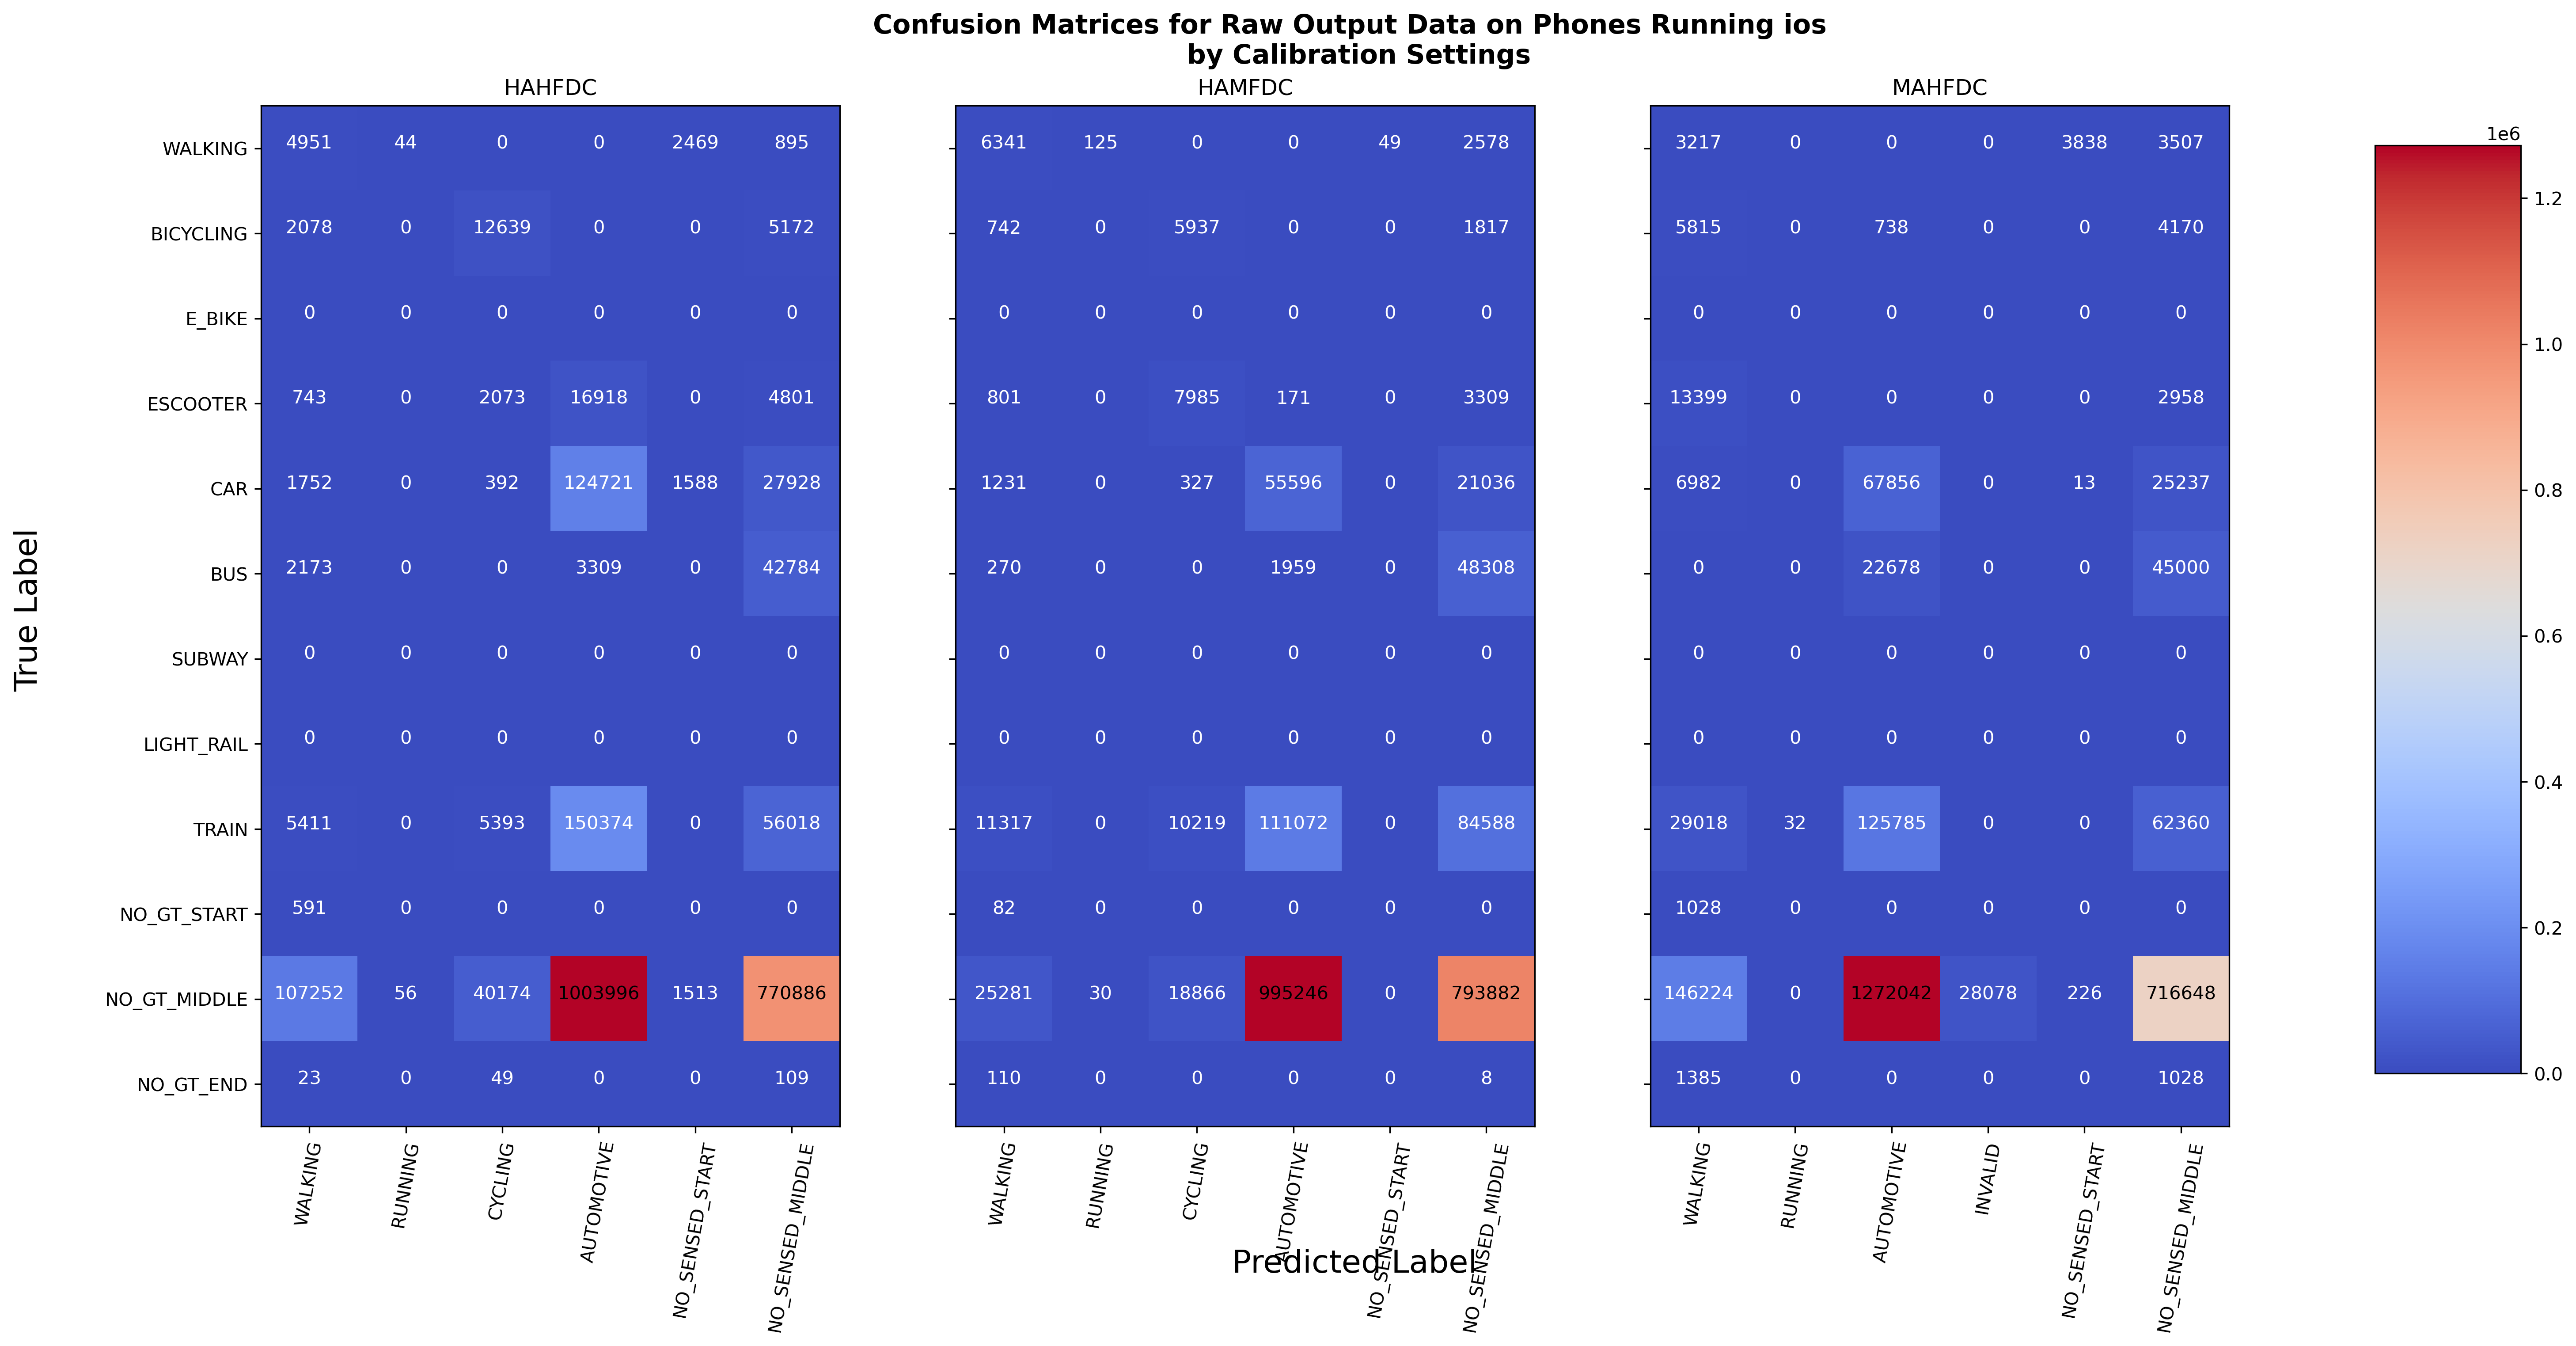

In [42]:
plot_cm('ios', [pv_la, pv_sj, pv_ucb], 'raw')

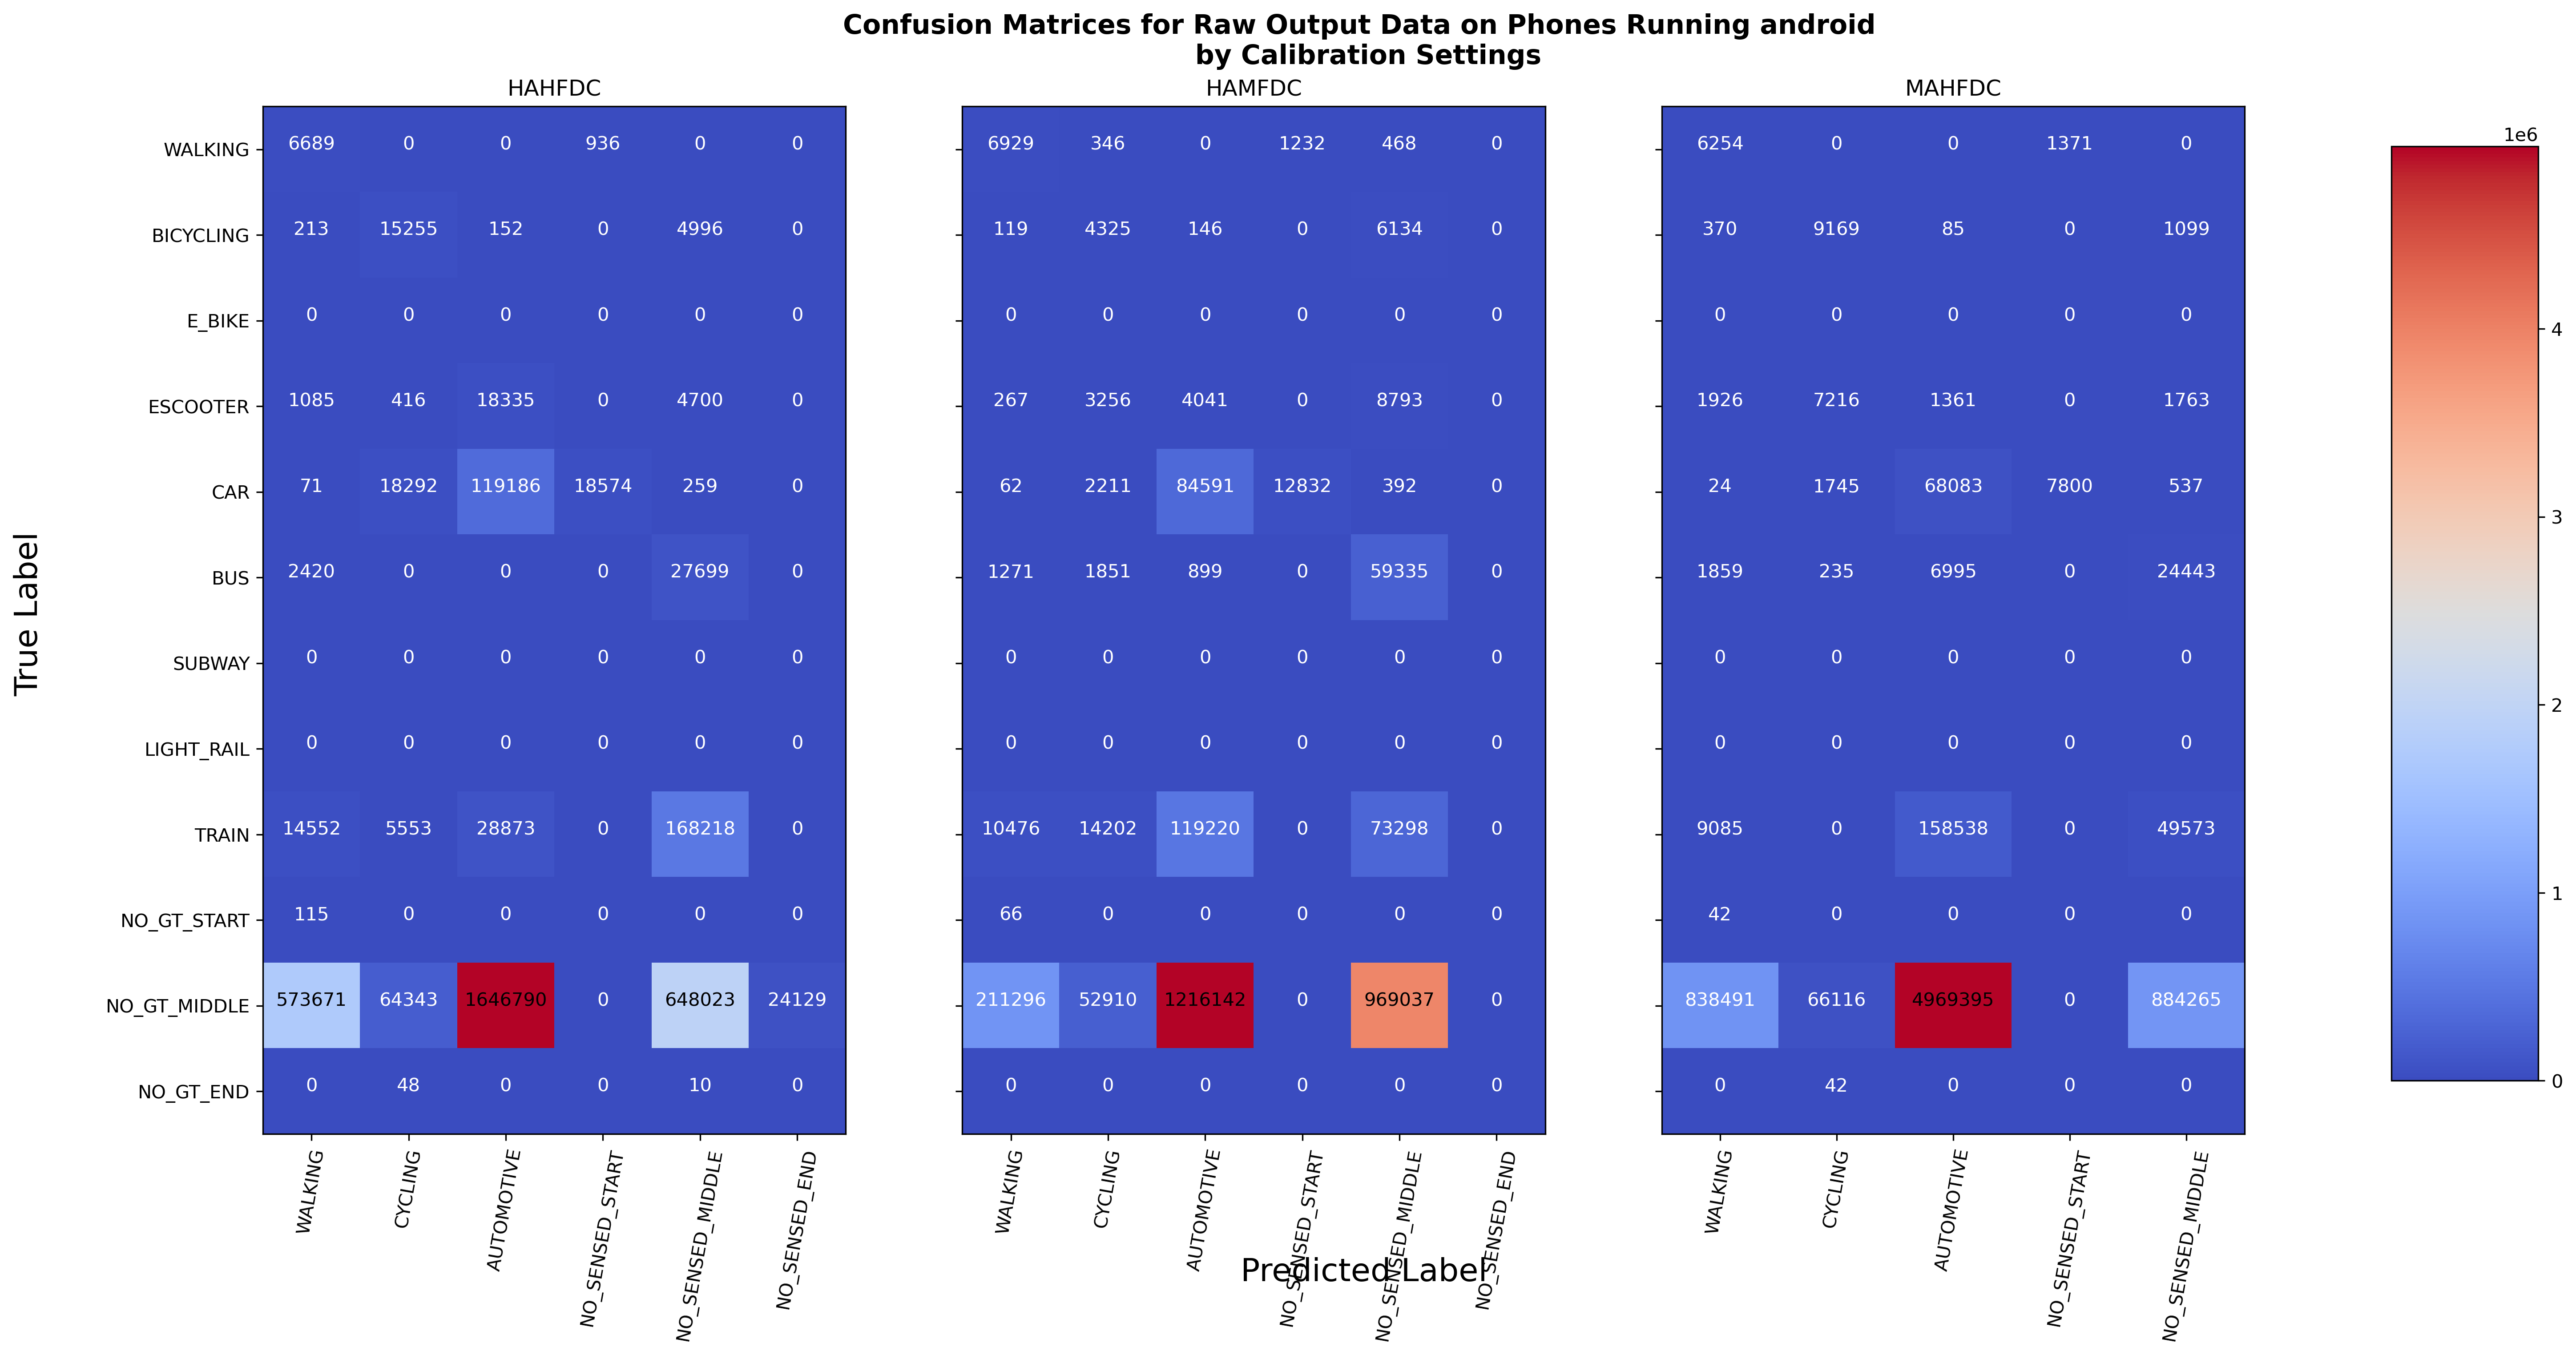

In [44]:
plot_cm('android', [pv_la, pv_sj, pv_ucb], 'raw')

#### Cleaned data

In [ ]:
plot_cm('ios', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM)

In [ ]:
plot_cm('android', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM)

#### Random Forrest

In [ ]:
plot_cm('ios', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM)

In [ ]:
plot_cm('android', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM)

#### GIS

In [236]:
# pv_la = eipv.PhoneView(sd_la)
# ems.fill_sensed_section_ranges(pv_la)
# get_confusion_matrix('ios', 'HAHFDC', pv_la)
# plot_cm('ios', pv_la, 'gis', INDEX_MAP=IIM)

# create list of all trips for each OS
ios_trips = []
android_trips = []
for role in ['HAHFDC', "HAMFDC", 'MAHFDC']:
    for pv in [gisv_la, gisv_sj, gisv_ucb]:
        ios_trips.extend(get_trip_ss_and_gts_timeline(pv, 'ios', role))
        android_trips.extend(get_trip_ss_and_gts_timeline(pv, 'android', role))

# get confusion matrices for both
two_CMs = []
for set in [android_trips, ios_trips]:
    cm_l = []
    for trip in set:
        ss_timeline, gt_timeline = align_timelines(trip)
        for ss in ss_timeline:
            cm = {}
            for gts in gt_timeline:
                if ss['end_distance'] >= gts['start_distance'] and ss['start_distance'] <= gts['end_distance']:
                    distance = min(ss['end_distance'], gts['end_distance']) - max(ss['start_distance'], gts['start_distance'])
                    cm[gts['mode']] = cm.setdefault(gts['mode'], 0) + distance
            cm['sensed_mode'] = ss['mode']
            
            cm_l.append(cm)
    two_CMs.append(cm_l)

# print(two_CMs)

# convert each CM into a dataframe
android_df = pd.DataFrame(two_CMs[0]).groupby('sensed_mode').sum().rename(index=IIM)
android_df = pd.DataFrame(android_df, index=sorted(android_df.index, key=sort_key))

ios_df = pd.DataFrame(two_CMs[1]).groupby('sensed_mode').sum().rename(index=IIM)
ios_df = pd.DataFrame(ios_df, index=sorted(ios_df.index, key=sort_key))

# save each df to a csv file
# android_df.to_csv('mobilitynet_android.csv')
# ios_df.to_csv('mobilitynet_ios.csv')
print(ios_df)

                      WALKING  NO_GT_MIDDLE           CAR    BICYCLING  \
WALKING          17202.880001   4550.305707   6637.834059  1292.927652   
BICYCLING        13028.929322   4923.834973  23752.368827 21389.877349   
CAR               6514.991783   9277.305765 287942.647302     0.000000   
BUS               1997.508540   7725.510987   1528.140772     0.000000   
SUBWAY               0.000000  25580.308350      0.000000     0.000000   
TRAIN             7586.345076  25266.772832      0.000000     0.000000   
UNKNOWN              0.000000      0.000000      0.000000     0.000000   
NO_SENSED_START  11439.742030    159.389378   4166.480877  3575.115098   
NO_SENSED_MIDDLE  1324.524114   2615.751533  10039.509833   236.537723   
NO_SENSED_END        0.000000      0.000000      0.000000     0.000000   

                     ESCOOTER           BUS          TRAIN        SUBWAY  \
WALKING           6264.664862  33799.862143   22225.856058  39309.607384   
BICYCLING        25059.212230  12

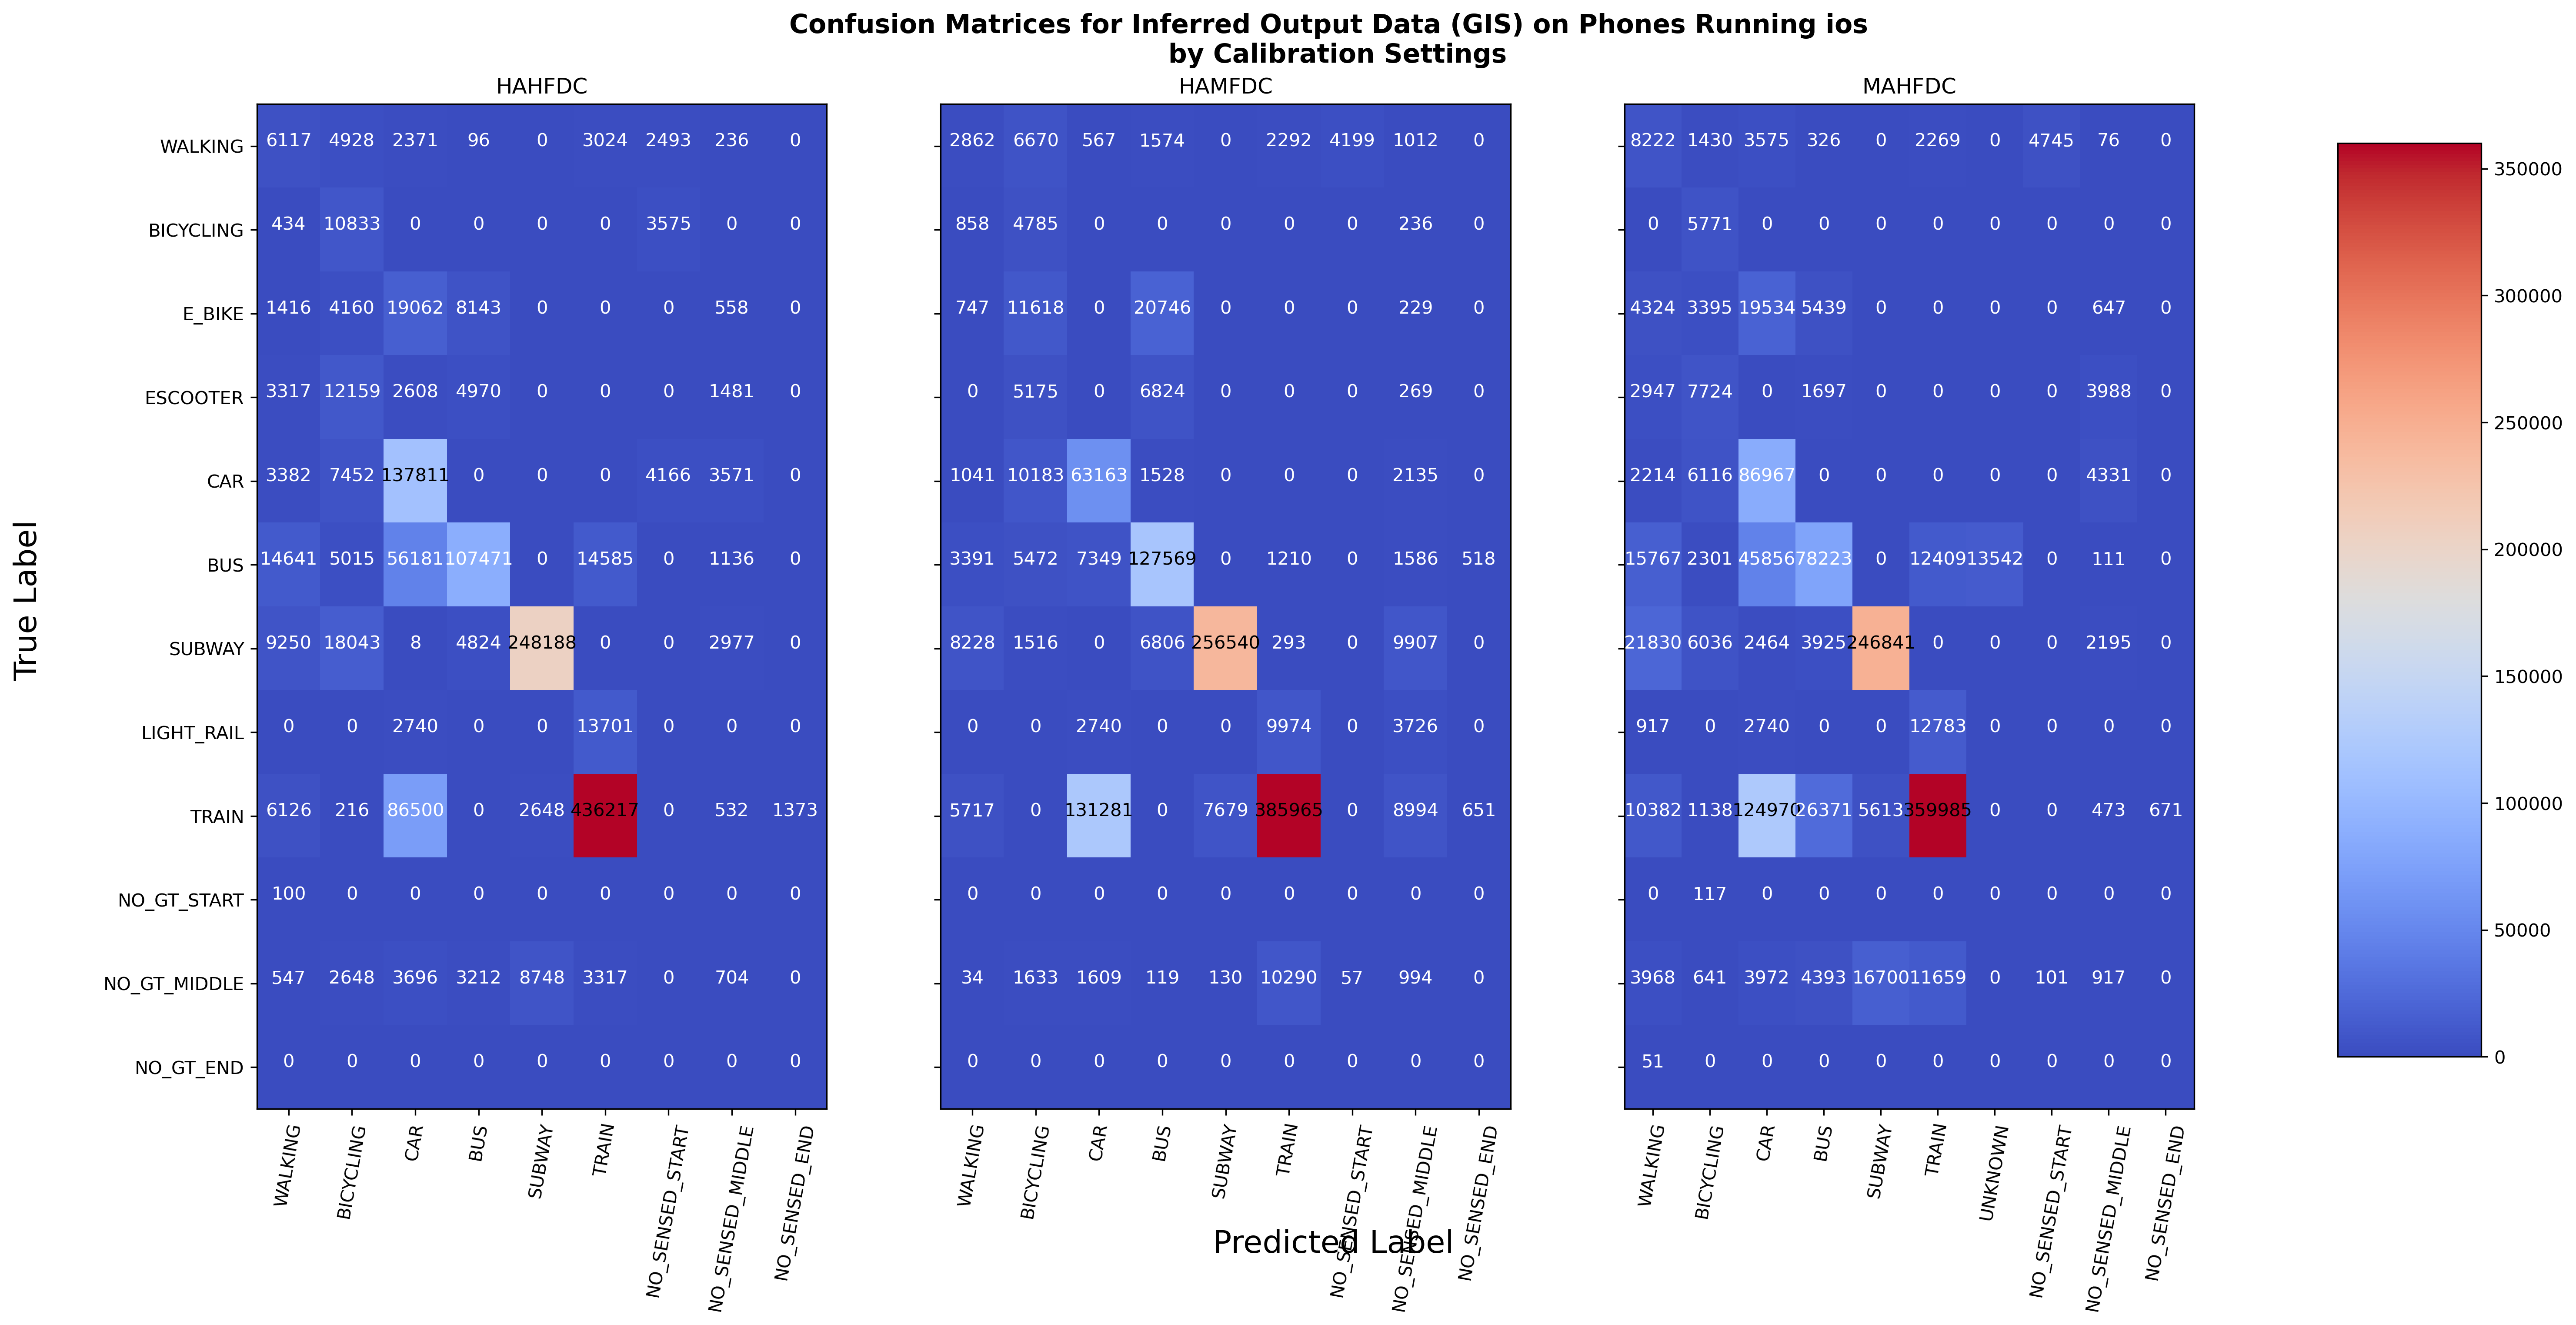

In [240]:
plot_cm('ios', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM)

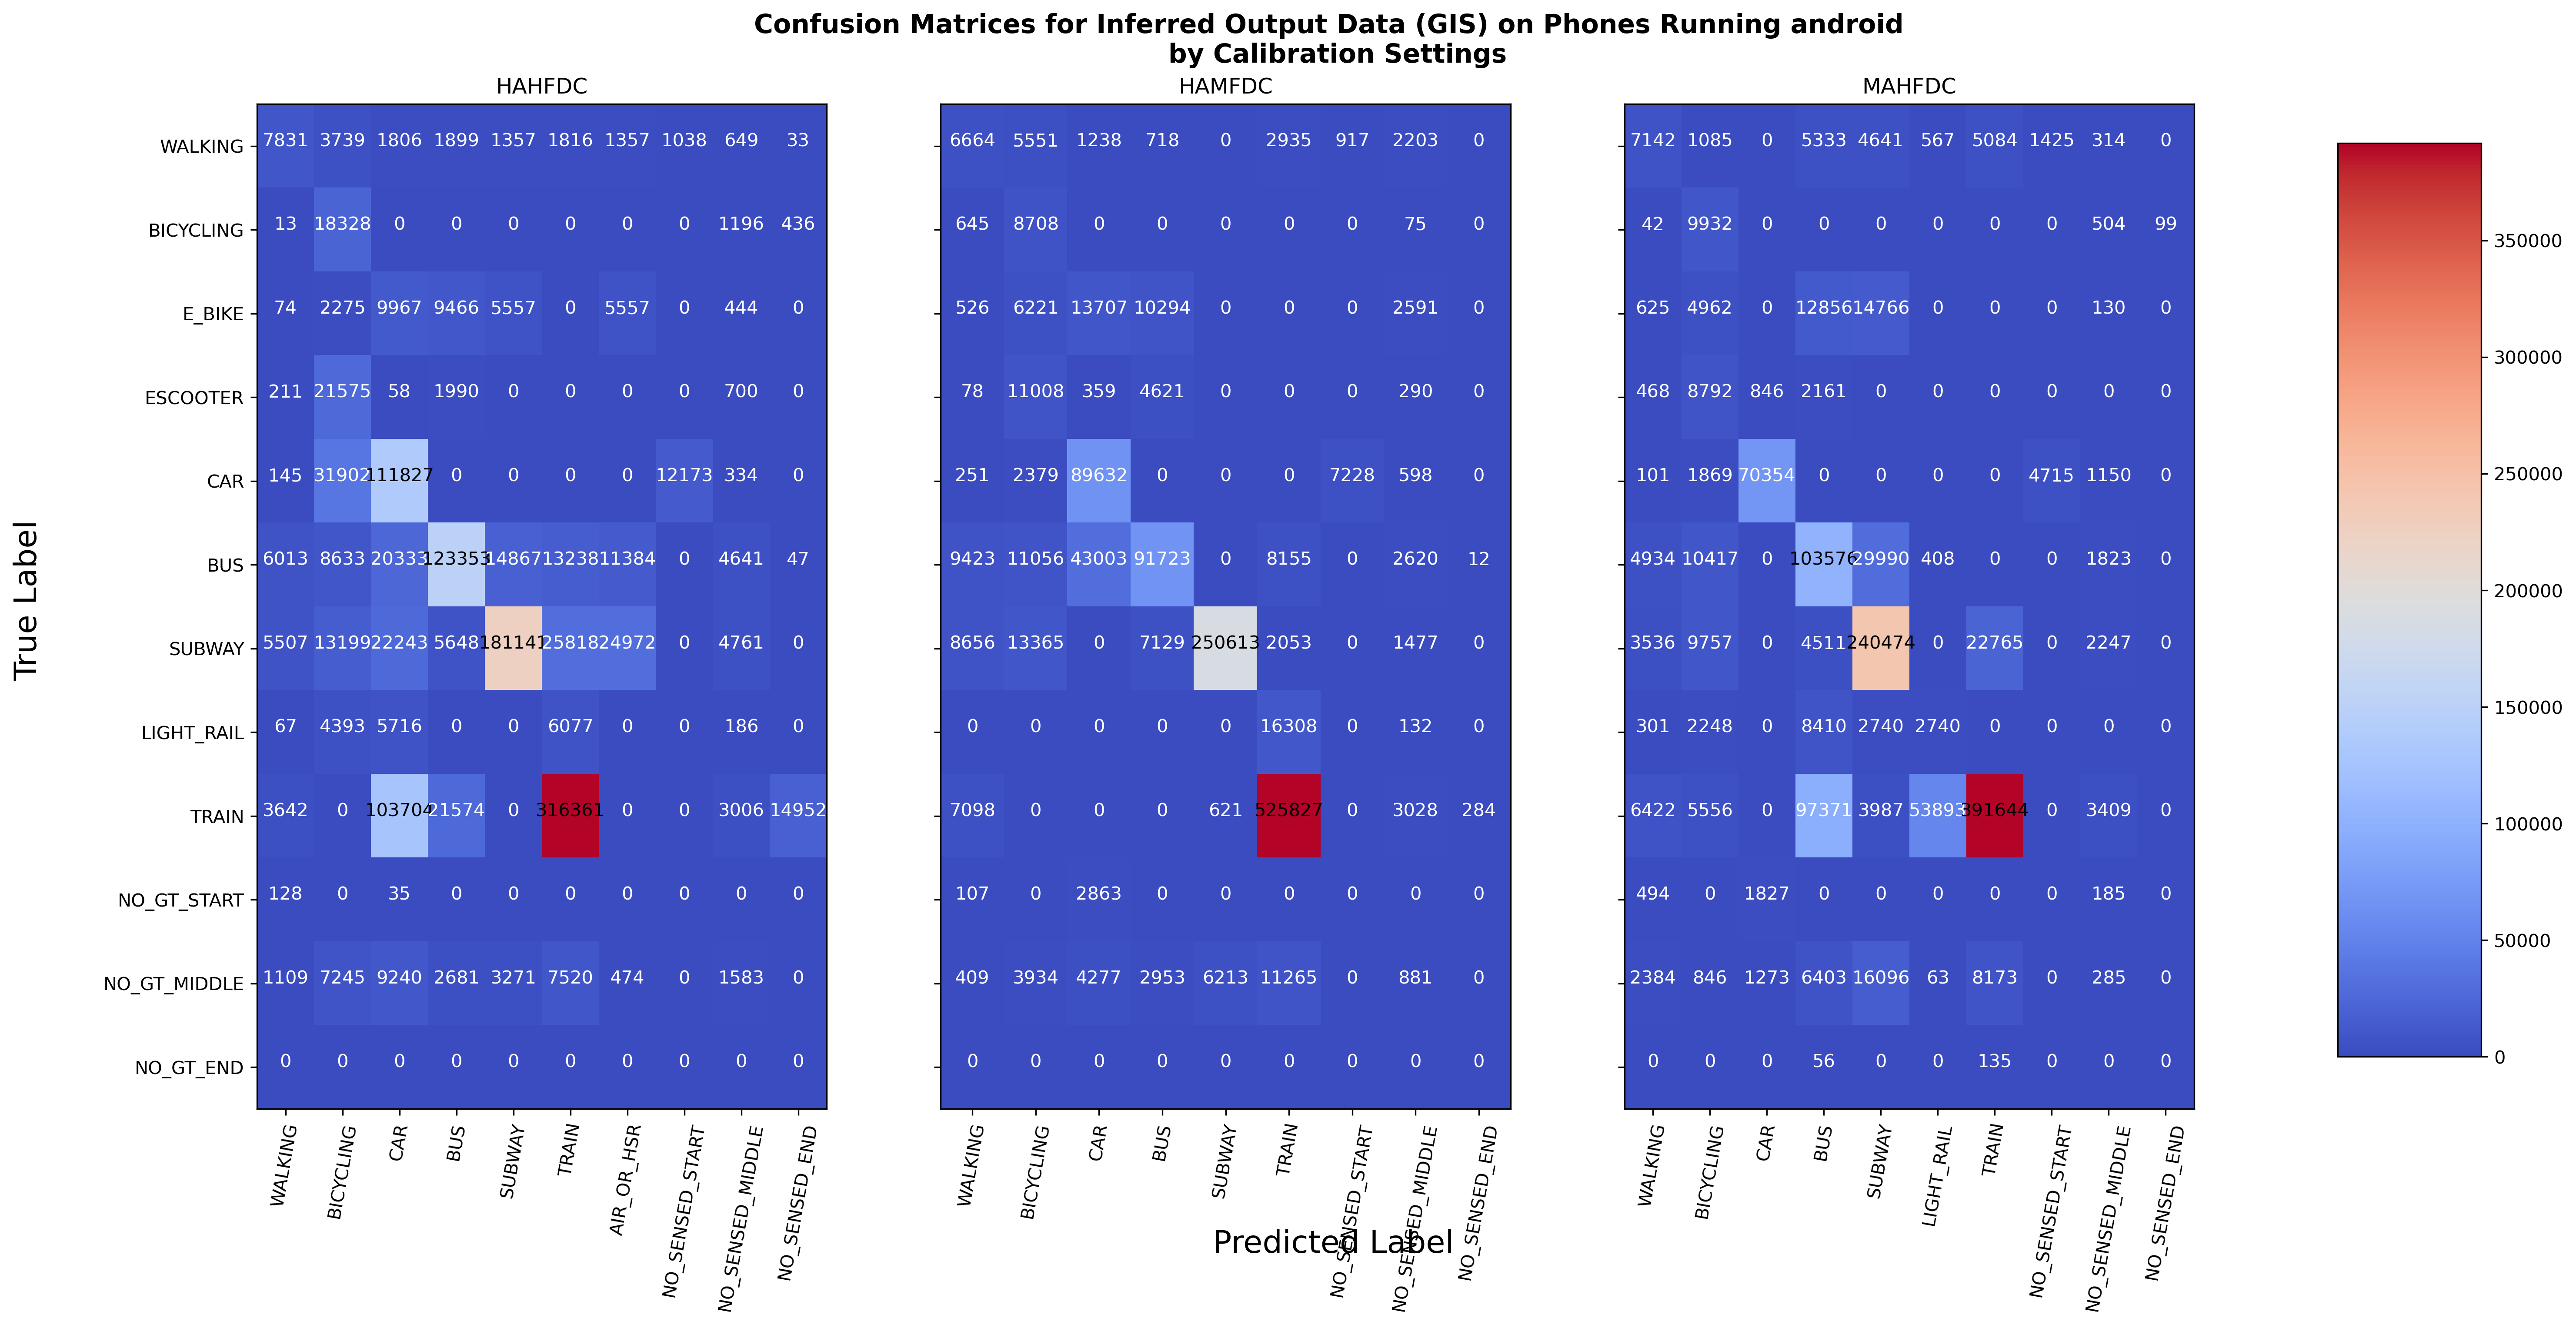

In [178]:
plot_cm('android', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM)

## Combined views

In [ ]:
plot_f_scores('ios')

In [ ]:
plot_f_scores('android')

## Selected Setting

In [ ]:
plot_select_cm('ios', 'HAHFDC')

In [ ]:
plot_select_cm('android', 'HAMFDC')

In [ ]:
plot_f_scores_selected()

In [ ]:
print(
    "GIS android \t",weighted_f_score('android', 'HAMFDC', [gisv_la,gisv_sj,gisv_ucb], GISBMM), '\n',
    "GIS ios \t", weighted_f_score('ios', 'HAHFDC', [gisv_la,gisv_sj,gisv_ucb], GISBMM)
)
print(
    "Random Forest android \t",weighted_f_score('android', 'HAMFDC', [rfv_la,rfv_sj,rfv_ucb], GISBMM), '\n',
    "Random Forest ios \t",weighted_f_score('ios', 'HAHFDC', [rfv_la,rfv_sj,rfv_ucb], GISBMM)
)

#### get percentage of no sensed predicted mode for a given ground truth mode (in this case ground truth mode = walking)

In [ ]:
for pv_l in [[pv_la, pv_sj, pv_ucb],[mcv_la, mcv_sj, mcv_ucb],[rfv_la,rfv_sj,rfv_ucb],[gisv_la,gisv_sj,gisv_ucb]]:
    df = pd.DataFrame(get_confusion_matrix('android', 'HAMFDC', pv_l)).groupby('sensed_mode').sum().rename(index=IIM)
    w_n = (df['WALKING']['NO_SENSED_START'] + df['WALKING']['NO_SENSED_MIDDLE'] + df['WALKING']['NO_SENSED_END'])
    print("NO_SENSED trip perdiction for WALKING android:HAMFDC: \t", w_n / df['WALKING'].sum())
    df = pd.DataFrame(get_confusion_matrix('ios', 'HAHFDC', pv_l)).groupby('sensed_mode').sum().rename(index=IIM)
    try:
        w_n = (df['WALKING']['NO_SENSED_START'] + df['WALKING']['NO_SENSED_MIDDLE'] + df['WALKING']['NO_SENSED_END'])
    except:
        w_n = (df['WALKING']['NO_SENSED_START'] + df['WALKING']['NO_SENSED_MIDDLE'])
    print("NO_SENSED trip perdiction for WALKING ios:HAHFDC: \t", w_n / df['WALKING'].sum())

# Unit Testing

* get_binary_class_in_sec(os, role, pv, BASE_MODE, test=False, test_trip=None)
* get_F_score(os, role, pv, BASE_MODE, beta=1, test=False, test_trip=None)
* get_confusion_matrix(os, role, pv, test=False, test_trip=None)

## Example timelines

### No sensed at the beggining, No GT at the end, Multimodal


* pipeline timeline

WALKING (0.5, 1.35) -> CYCLING (1.35, 2.7) -> WALKING (2.7, 3.5)

* ground truth timeline

WALKING (0, 1.05) -> BICYCLING (1.05, 3.1)

#### binary classifiers
    + TP 
        + [WALKING: 0.55] 
        + [CYCLING: 1.35]
    + FP 
        + [WALKING: 1.10] 
        + [INVALID: 0.5]
    + FN 
        + [WALKING: 0.50] 
        + [CYCLING: 0.70]
        + [INVALID: 0.4]
    + TN 
        + [WALKING: 1.35] 
        + [CYCLING: 1.45]
        + [INVALID: 2.60]
* $F_1$ score
    + [WALKING: 0.41]
    + [CYCLING: 0.79]
    + [INVALID: ....]
    
#### Confusion Matrix


sensed = [WALKING, CYCLING, NO_SENSED]

ground truth = [WALKING, BICYCLING, NO_GT]

origin top left

    [0.55, 0.00, 0.50]
    [0.70, 1.35, 0.00]
    [0.40, 0.00, 0.00]

In [ ]:
test_trip = {
    'ss_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.35, 'mode' : 'WALKING'},
                      {'start_ts' : 1.35, 'end_ts' : 2.7, 'mode' : 'CYCLING'}, 
                      {'start_ts' : 2.7, 'end_ts' : 3.5, 'mode' : 'WALKING'}],
    'gts_timeline' : [{'start_ts' : 0, 'end_ts' : 1.05, 'mode' : 'WALKING'}, 
                      {'start_ts' : 1.05, 'end_ts' : 3.1, 'mode' : 'BICYCLING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'CYCLING' : 'CYCLING', 'BICYCLING' : 'CYCLING', 
            'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID', 
            'NO_SENSED_START' : 'INVALID', 'NO_SENSED_MIDDLE' : 'INVALID', 'NO_SENSED_END' : 'INVALID', 
            'NO_GT_START' : 'INVALID', 'NO_GT_MIDDLE' : 'INVALID', 'NO_GT_END' : 'INVALID'}

#### get_binary_class_in_sec

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert round(res[0]['WALKING'], 2) == 0.55 and round(res[0]['CYCLING'], 2) == 1.35, f"TP wrong"
assert round(res[1]['WALKING'], 2) == 1.10 and round(res[1]['INVALID'], 2) == 0.50 and len(res[1]) == 2, f"FP wrong"
assert round(res[2]['WALKING'], 2) == 0.50 and round(res[2]['CYCLING'], 2) == 0.70 and round(res[2]['INVALID'], 2) == 0.40 and len(res[2]) == 3, f"FN wrong"
assert round(res[3]['WALKING'], 2) == 1.35 and round(res[3]['CYCLING'], 2) == 1.45 and round(res[3]['INVALID'], 2) == 2.60 and len(res[2]) == 3, f"TN wrong"

#### get_F_score

In [ ]:
res = get_F_score(..., ..., ..., test_BMM, beta=1, test=True, test_trip=test_trip)
assert round(res['WALKING'],2) == 0.41 and round(res['CYCLING'], 2) == 0.79 and res['INVALID'] == 0, f"F_1 scores wrong"

#### get_confusion_matrix

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()
assert 'WALKING' in df.index and 'CYCLING' in df.index and 'NO_SENSED_START' in df.index, f"INCORRECT INDECIES \n EXPECTED \t 'WALKING', 'CYCLING', 'NO_SENSED' \n GOT \t \t {df.index}"
assert df.loc['WALKING'].loc['WALKING'] == 0.55 and df.loc['WALKING'].loc['BICYCLING'] == 0.70 and round(df.loc['WALKING'].loc['NO_GT_END'],2) == 0.40
assert df.loc['CYCLING'].loc['WALKING'] == 0 and df.loc['CYCLING'].loc['BICYCLING'] == 1.35 and round(df.loc['CYCLING'].loc['NO_GT_END'],2) == 0.0
assert round(df.loc['NO_SENSED_START'].loc['WALKING'], 2) == 0.50 and df.loc['NO_SENSED_START'].loc['BICYCLING'] == 0.0 and round(df.loc['NO_SENSED_START'].loc['NO_GT_END'],2) == 0.0

### No sensed at beggining and end, multimodal

* pipeline timeline
WALKING (0.5, 1.5)

* ground truth timeline
WALKING (0, 1) -> (1, 2)

#### Multiclass classifiers
* TP
    + WALKING [0.5]
* FP
    + WALKING [0.5]
    + INVALID [1]
* FN
    + WALKING [0.5]
    + CYCLING [1]
* TN
    + WALKING [0.5]
    + CYCLING [1]
    + INVALID [1]
#### Confusion Matrix

sensed mode = ['WALKING', 'NO_SENSED']

ground truth = ['WALKING', 'CYCLING']

    [0.5, 0.5]
    [0.5, 0.5]

In [ ]:
test_trip = {
    'ss_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.5, 'mode' : 'WALKING'}],
    'gts_timeline' : [{'start_ts' : 0, 'end_ts' : 1, 'mode' : 'WALKING'}, {'start_ts' : 1, 'end_ts' : 2, 'mode' : 'CYCLING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'CYCLING' : "CYCLING", 'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID',
            'NO_SENSED_START' : 'INVALID', 'NO_SENSED_MIDDLE' : 'INVALID', 'NO_SENSED_END' : 'INVALID', 
            'NO_GT_START' : 'INVALID', 'NO_GT_MIDDLE' : 'INVALID', 'NO_GT_END' : 'INVALID'}

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert res[0]['WALKING'] == 0.5
assert res[1]['INVALID'] == 1.0 and res[1]['WALKING'] == 0.5
assert res[2]['WALKING'] == 0.5 and res[2]['CYCLING'] == 1 
assert res[3]['WALKING'] == 0.5 and res[3]['CYCLING'] == 1 and res[3]['INVALID'] == 1

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()

In [ ]:
assert df.loc['WALKING'].loc['WALKING'] == 0.5
assert df.loc['WALKING'].loc['CYCLING'] == 0.5
assert df.loc['NO_SENSED_START'].loc['WALKING'] == 0.5
assert df.loc['NO_SENSED_END'].loc['CYCLING'] == 0.5

### No ground truth at beggining and end, unimodal

* pipeline timeline
WALKING (0, 2)

* ground truth timeline
WALKING (0.5, 1.5)

#### Multiclass classifiers
* TP
    + WALKING [1]
* FP
    + WALKING [1]
* FN
    + INVALID [1]
* TN
    + INVALID [1]
* $F_1$ score
    + ...
#### Confusion Matrix

sensed mode = ['WALKING']

ground truth = ['WALKING', 'NO_GT]

    [1,1]

In [ ]:
test_trip = {
    'gts_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.5, 'mode' : 'WALKING'}],
    'ss_timeline' : [{'start_ts' : 0, 'end_ts' : 2, 'mode' : 'WALKING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID',
            'NO_SENSED_START' : 'INVALID', 'NO_SENSED_MIDDLE' : 'INVALID', 'NO_SENSED_END' : 'INVALID', 
            'NO_GT_START' : 'INVALID', 'NO_GT_MIDDLE' : 'INVALID', 'NO_GT_END' : 'INVALID'}

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert res[0]['WALKING'] == 1
assert res[1]['WALKING'] == 1
assert res[2]['INVALID'] == 1
assert res[3]['INVALID'] == 1

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()

In [ ]:
assert df.loc['WALKING'].loc['WALKING'] == 1
assert df.loc['WALKING'].loc['NO_GT_START'] == 0.5
assert df.loc['WALKING'].loc['NO_GT_END'] == 0.5

## Unimodal Sensed Timeline With Gap

* sensed timeline
    + WALKING(2, 4) -> CYCLING(6, 8)
* ground truth timeline
    + WALKING(0, 10)
    
#### Classifiers

* TP
    + WALKING [2]
* FP
    + NO_SENSED [6]
    + CYCLING [2]
* FN
    + WALKING [8]
* TN
    + INVALID [4]
    + CYCLING [8]

In [ ]:
test_trip = [
    {
        'gts_timeline'  : [{'start_ts' : 0, 'end_ts' : 10, 'mode' : 'WALKING'}],
        'ss_timeline' : [
            {'start_ts' : 2, 'end_ts' : 4, 'mode' : 'WALKING'},
            {'start_ts' : 6, 'end_ts' : 8, 'mode' : 'CYCLING'}
        ]
    }
]
test_BMM = {'WALKING' : 'WALKING', 'CYCLING' : 'CYCLING', 'NO_SENSED' : 'NO_SENSED', 'NO_GT' : 'NO_GT',
            'NO_SENSED_START' : 'NO_SENSED', 'NO_SENSED_MIDDLE' : 'NO_SENSED', 'NO_SENSED_END' : 'NO_SENSED', 
            'NO_GT_START' : 'NO_GT', 'NO_GT_MIDDLE' : 'NO_GT', 'NO_GT_END' : 'NO_GT'}

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert res[0]['WALKING'] == 2, f"WALKING TP IS INCORRECT, SHOULD BE 4, GOT {res[0]['WALKING']}"
assert res[1]['NO_SENSED'] == 6, f"NO_SENSED FP IS INCORRECT, SHOULD BE 6, GOT {res[1]['NO_SENSED']}"
assert res[1]['CYCLING'] == 2, f"CYCLING FP IS INCORRECT, SHOULD BE 2, GOT {res[1]['CYCLING'] }"
assert res[2]['WALKING'] == 8, f"WALKING FN IS INCORRECT, SHOULD BE 8, GOT {res[2]['WALKING'] }"
assert res[3]['NO_SENSED'] == 4, f"NO_SENSED TN IS INCORRECT, SHOULD BE 4, GOT {res[3]['NO_SENSED']}"
assert res[3]['CYCLING'] == 8, f"CYCLING TN IS INCORRECT, SHOULD BE 8, GOT {res[3]['CYCLING']}"
assert res[3]['NO_GT'] == 10, f"NO_GT TN IS INCORRECT, SHOULD BE 10, GOT {res[3]['NO_GT']}"

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()

## Unimodal Sensed Timeline With Gap
### Flip of last trip
* ground truth timeline
    + WALKING(2, 4) -> CYCLING(6, 8)
* sensed timeline
    + WALKING(0, 10)

In [ ]:
flip = [{'gts_timeline' : test_trip[0]['ss_timeline'], 'ss_timeline' : test_trip[0]['gts_timeline']}]

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=flip)

In [ ]:
assert res[0]['WALKING'] == 2, f"WALKING TP IS INCORRECT, SHOULD BE 4, GOT {res[0]['WALKING']}"
assert res[1]['WALKING'] == 8, f"WALKING FP IS INCORRECT, SHOULD BE 8, GOT {res[2]['WALKING']}"
assert res[2]['NO_GT'] == 6, f"NO_GT TN IS INCORRECT, SHOULD BE 6, GOT {res[3]['NO_GT'] }"
assert res[2]['CYCLING'] == 2, f"CYCLING TN IS INCORRECT, SHOULD BE 2, GOT {res[3]['CYCLING'] }"
assert res[3]['CYCLING'] == 8, f"CYCLING TN IS INCORRECT, SHOULD BE 8, GOT {res[3]['CYCLING']}"
assert res[3]['NO_SENSED'] == 10, f"NO_SENSED TN IS INCORRECT, SHOULD BE 10, GOT {res[3]['NO_SENSED']}"
assert res[3]['NO_GT'] == 4, f"NO_GT TN IS INCORRECT, SHOULD BE 4, GOT {res[3]['NO_GT']}"

## No ss, gts

In [ ]:
test_trip = [{'gts_timeline'  : [], 'ss_timeline' : []}]
get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

## No ss

In [ ]:
test_trip = [{'gts_timeline'  : [{'mode' : 'WALKING', 'start_ts' : 0, 'end_ts' : 1}], 'ss_timeline' : []}]
get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

## No gts

In [ ]:
test_trip = [{'ss_timeline'  : [{'mode' : 'WALKING', 'start_ts' : 0, 'end_ts' : 1}], 'gts_timeline' : []}]
get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)